## Alexandra Gavrilina

# HOMEWORK 1: HIDDEN MARKOV MODEL

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import random

###  Beginning distribution (vector of length M).

In [2]:
'''
Beginning distribution (as stationary distribution)
Input: transition matrix A
Output: beginning distribution (as stationary distribution) \pi
'''
def beginning_distribution(A):
    n = A.shape[0]
    M = np.vstack(((A.transpose() - np.eye(n))[:-1], np.ones(n)))
    v = np.eye(n)[-1]
    p = np.linalg.solve(M, v)
    return p

### HMM random generator: generate a sequence $x$ of length $L$ given the model parameters.

In [3]:
'''
Weighted random generation
Input: weights
Output: next state according to weigted probability array
'''
def generate_st(weights):
    totals = []
    running_total = 0

    for w in weights:
        running_total += w
        totals.append(running_total)

    rnd = random.random() * running_total
    for i, total in enumerate(totals):
        if rnd < total:
            return i

In [4]:
'''
Function for generation a sequence of hidden states
Input: sequence length, beginning distribution, transition matrix
Output: hidden states
'''
def hidden_seq(L, pi, A):
    out = [0 for i in range(L)]
    out[0] = generate_st(pi)
    for i in range(1, L):
        out[i] = generate_st(A[out[i-1]])
    return out

In [5]:
'''
Function for generation a sequence of observed states
Input: hidden states
Output: observed states
'''
def obs_seq(hidden):
    out = [0 for i in range(L)]
    for i in range(L):
        out[i] = generate_st(E[hidden[i]])
    return out

In [6]:
'''
Viterbi algorithm
Input: transition probability matrix, emission matrix, sequence length
Output: returns the most likely state sequence given observed sequence x
'''
def Viterbi_algorithm(obs_seq, pi, A, B):
    T = len(obs_seq)
    M = A.shape[0]
    
    delta = np.zeros((T, M)) 
    delta[0] = np.log(pi * B[:, obs_seq[0]])
    
    psi = np.zeros((T-1, M)) # prev
    
    for t in range(1, T):
        for j in range(M):
            probability = delta[t - 1] + np.log(A[:, j]) + np.log(B[j, obs_seq[t]])
            
            psi[t - 1, j] = np.argmax(probability)
            
            delta[t, j] = np.max(probability)
            

    # backtrack
    states = np.zeros(T, dtype=np.int32)
    
    states[T-1] = np.argmax(delta[T - 1])
    
    back_index = 1
    for t in range(T-2, -1, -1):
        states[back_index] = psi[t, int(states[0])]
        states[0] = psi[t, int(states[0])]
        back_index += 1
        
    states = np.flip(states, axis=0)
    
    return states

### Find the probability $P(x)$ using forward algorithm (store the full matrix of forward probabilities $f_k(x_i)$ in order to use it for posterior decoding later on).

#### Algorithm: Backward algorithm

Initialisation $(i = 0)$: $f_0 (0) = 1, f_k(0) = 0$ for $k > 0$.

Recursion $(i = 1, \ldots, L)$: $f_l(i) = e_l (x_i) \sum\limits_{k} f_k(i-1) a_{kl}$.

Termination: $P(x) = \sum\limits_{k} f_{k} (L) a_{k0}$.

In [7]:
'''
Forward algorithm
Input: array of observations, initial distribution, transition matrix, emission matrix
Output: resulting matrix, probability of observation
'''
def forward(obs_seq, pi, A, B):
    T = len(obs_seq)
    N = A.shape[0]
    
    forw = np.zeros((T, N))
    forw[0] = pi*B[:, obs_seq[0]]
    
    for t in range(1, T):
        forw[t] = np.dot(forw[t - 1], A) * B[:, obs_seq[t]]
    
    proba = forw[-1].sum()
    
    return forw, proba

### Implement the backward algorithm

#### Algorithm: Backward algorithm

Initialisation $(i = L)$: $b_k (L) = a_{k0}$ for all $k$.

Recursion $(i = L-1, \ldots, 1)$: $b_k(i) = \sum\limits_{l} a_{kl} e_l (x_{i+1}) b_l(i+1)$.

Termination: $P(x) = \sum\limits_{l} a_{0l} e_l (x_1) b_l (1)$.

In [8]:
'''
Backward algorithm
Input: array of observations, transition matrix, emission matrix
Output: resulting matrix, probability of observation
'''
def backward(obs_seq, A, B):
    N = A.shape[0]
    T = len(obs_seq)

    back = np.zeros((N, T))
    back[:, -1:] = 1

    for t in reversed(range(T-1)):
        for n in range(N):
            back[n, t] = np.sum(back[:, t+1] * A[n, :] * B[:, obs_seq[t+1]])
    
    proba = np.sum(pi * B[:, obs_seq[0]] * back[:,0])

    return back, proba

### Simulate occasionally unfair casino: one dice has equal probabilities of each face $P(i) = 1/6, i = 1, 2, 3, 4, 5, 6$ and another dice has probability $P(6) = 0,5$ and all other outcomes have probability $0,1$. The probability to switch from the fair dice to the loaded dice is $0,05$, the probability to switch from the loaded to the fair dice is $0,1$. The beginning distribution is the stationary distribution of the underlying Markov chain.

### Set transition (M $\times$ M) and emission (M $\times$ K) matrices

$\pi$: initial distribution (vector of length $M$)

$A$: transition matrix ($M \times M$)

$E$: emission matrix ($M \times K$)

$L$: number of the rolls

In [9]:
A = np.array([[0.95, 0.05], [0.1, 0.9]]) 
E = np.array([[1.0/6 for i in range(6)], [0.1, 0.1, 0.1, 0.1, 0.1, 0.5]]) 
L = 300 # number of the rolls

In [10]:
pi = beginning_distribution(A)
pi # np.array([2.0/3.0, 1.0/3.0])

array([0.66666667, 0.33333333])

In [11]:
hidden = np.array(hidden_seq(L, pi, A))
observed = np.array(obs_seq(hidden))

In [12]:
hidden

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1])

In [13]:
observed

array([0, 4, 0, 2, 2, 5, 1, 4, 2, 5, 1, 2, 4, 0, 2, 4, 1, 1, 0, 0, 2, 4,
       3, 4, 5, 1, 0, 3, 1, 3, 3, 4, 2, 5, 5, 5, 5, 1, 2, 2, 0, 4, 3, 1,
       2, 1, 3, 0, 4, 3, 0, 4, 5, 1, 0, 5, 0, 5, 5, 4, 1, 3, 3, 5, 5, 5,
       4, 0, 5, 5, 5, 1, 5, 0, 3, 5, 3, 2, 5, 2, 5, 2, 1, 5, 1, 5, 5, 5,
       4, 0, 5, 2, 3, 5, 0, 5, 5, 3, 0, 4, 3, 5, 1, 0, 4, 2, 0, 0, 0, 5,
       2, 4, 4, 5, 1, 1, 3, 3, 2, 0, 0, 4, 4, 4, 3, 3, 0, 2, 3, 2, 2, 2,
       2, 2, 1, 2, 0, 0, 1, 5, 5, 0, 2, 5, 0, 2, 2, 1, 2, 0, 1, 5, 1, 5,
       5, 1, 0, 4, 4, 1, 0, 4, 2, 3, 4, 2, 3, 1, 4, 4, 1, 5, 0, 5, 0, 5,
       3, 3, 5, 5, 3, 5, 4, 5, 4, 4, 5, 3, 4, 4, 5, 5, 2, 5, 5, 0, 5, 5,
       2, 3, 2, 5, 4, 3, 2, 1, 2, 5, 0, 3, 2, 4, 5, 0, 5, 5, 5, 3, 2, 4,
       4, 3, 2, 0, 0, 2, 3, 5, 3, 1, 0, 2, 0, 0, 4, 0, 2, 4, 2, 5, 5, 5,
       1, 4, 5, 0, 0, 5, 5, 4, 5, 5, 2, 5, 4, 5, 5, 2, 2, 2, 2, 3, 5, 4,
       0, 5, 5, 1, 0, 3, 5, 5, 5, 5, 2, 0, 0, 2, 3, 3, 0, 5, 5, 0, 0, 5,
       5, 5, 5, 5, 3, 5, 5, 2, 5, 0, 5, 5, 1, 1])

Viterbi path

In [14]:
path = Viterbi_algorithm(observed, pi, A, E)
path

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0])

$P(x)$ using forward algorithm

In [15]:
forw, prob_forw = forward(observed, pi, A, E)
prob_forw

7.395904473608019e-225

$P(x)$ using backward algorithm

In [16]:
back, prob_back = backward(observed, A, E)
prob_back

7.395904473608024e-225

Posterior probabilities

In [17]:
post_prob=(np.multiply(forw, back.T) / prob_forw)
post_prob

array([[0.91546968, 0.08453032],
       [0.93369135, 0.06630865],
       [0.93924896, 0.06075104],
       [0.93410513, 0.06589487],
       [0.91644339, 0.08355661],
       [0.8800267 , 0.1199733 ],
       [0.90734716, 0.09265284],
       [0.91678753, 0.08321247],
       [0.91168157, 0.08831843],
       [0.89022616, 0.10977384],
       [0.93134126, 0.06865874],
       [0.95421608, 0.04578392],
       [0.96692859, 0.03307141],
       [0.97396805, 0.02603195],
       [0.97782034, 0.02217966],
       [0.97984585, 0.02015415],
       [0.98075988, 0.01924012],
       [0.98088519, 0.01911481],
       [0.98026604, 0.01973396],
       [0.97868378, 0.02131622],
       [0.97557965, 0.02442035],
       [0.96985749, 0.03014251],
       [0.95949657, 0.04050343],
       [0.94083807, 0.05916193],
       [0.90729298, 0.09270702],
       [0.93225776, 0.06774224],
       [0.94316119, 0.05683881],
       [0.94385366, 0.05614634],
       [0.93457973, 0.06542027],
       [0.91206441, 0.08793559],
       [0.

### Plot and compare the simulated path and Viterbi most likely path.

A Viterbi-path is a sequence of states maximizing the probability. If we compute a Viterbi-path for a unfair casino sequence of throws, the state sequence tells us when the casino was fair (state 0) and when it was unfair (state 1).

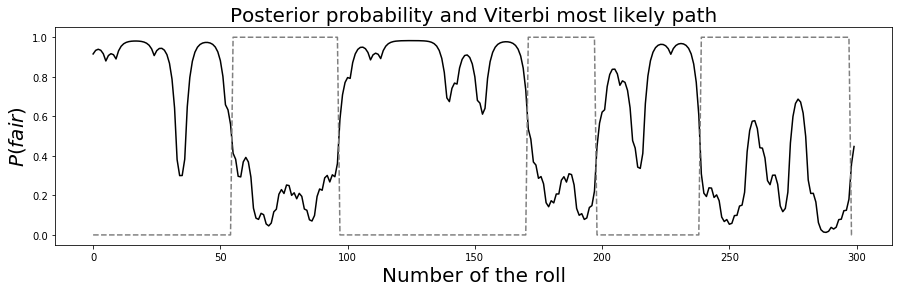

In [18]:
plt.figure(figsize=(15,4))
plt.xlabel('Number of the roll', fontsize=20)
plt.ylabel('$P(fair)$', fontsize=20)
plt.title('Posterior probability and Viterbi most likely path', fontsize = 20)
plt.plot(range(L), post_prob[:,0], color = 'black')
plt.plot(range(L), path[:], color = 'grey', linestyle='--')

### Plot posterior probability P(fair). Compare with the regions of the simulated path where loaded dice was used.

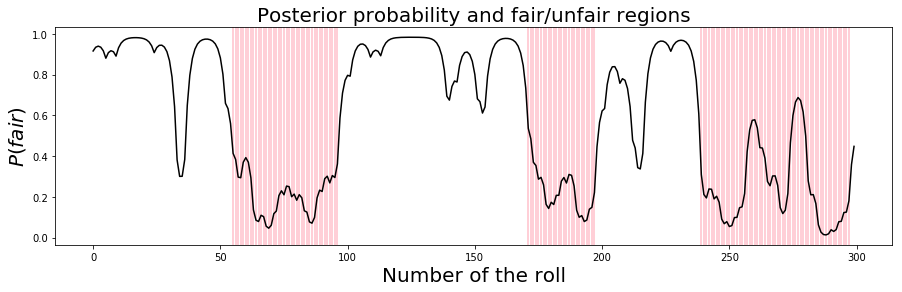

In [19]:
plt.figure(figsize=(15,4))
plt.xlabel('Number of the roll', fontsize=20)
plt.ylabel('$P(fair)$', fontsize=20)
for i in range(L):
    if path[i] == 0:
        plt.axvline(x = i, color ='white')
    else:
        plt.axvline(x = i, color = 'pink')
plt.title('Posterior probability and fair/unfair regions', fontsize = 20)
plt.plot(range(L), post_prob[:,0], color = 'black')

white - "Fair", pink - "Unfair"

## Baum-Welch training

This algorithm uses a special case of the Expectation Maximization (EM) Algorithm.

In [20]:
# transition matrix A for BW
A_BW = np.array([[0.8, 0.2], [0.3, 0.7]])
# emission matrix A for BW
E_BW = np.array([[0.1, 0.2, 0.3, 0.1, 0.1, 0.2], [0.05, 0.05, 0.1, 0.1, 0.6, 0.1]])

In [21]:
# initial distribution for BW
pi0_bw = beginning_distribution(A_BW)
pi0_bw

array([0.6, 0.4])

In [22]:
M = 2 # honest / dishonest
K = 6 # number of possible observed states

Estimation of the parameters of the transition matrix and emission matrix

In [23]:
hid_seq = hidden_seq(L, pi0_bw, A_BW)
observed_seq = obs_seq(np.array(hid_seq))

eps = 1e-06

'''
Estimation of the parameters of the transition matrix and emission matrix
Input: random transition and emission matrices
Output: estimated transition matrix and emission matrix

'''
def estimation(A_BW, E_BW):
    # using forward and backward algorithms
    f_k_bw = forward(observed_seq, pi0_bw, A_BW, E_BW)[0]
    forw_prob_bw = forward(observed_seq, pi0_bw, A_BW, E_BW)[1]
    b_k_bw = backward(observed_seq, A_BW, E_BW)[0]
    
    # transition matrix
    A = np.zeros((M, M))
    a = np.zeros((M, M))
    a_prev = np.zeros((M, M))

    for i in range(M):
        for j in range(M):
            for k in range(1, L - 1):
                A[i, j] += f_k_bw[k, i] * A_BW[i, j] * E_BW[j, observed_seq[k] - 1] * b_k_bw[j, k + 1]
    A /= forw_prob_bw
    
    for i in range(M):
        for j in range(M):
            a[i, j] = A[i, j] / np.sum(A[i])
            
    if np.allclose(a_prev, a, eps):
        a_prev, a = a, estimation(a, E_BW)[0]
    
    # emission matrix
    E = np.zeros((M, K))
    e = np.zeros((M, K))
    e_prev = np.zeros((M, K))

    for i in range(M):
        for j in range(K):
            for k in range(0, L):
                if observed_seq[k] == j + 1:
                    E[i, j] += f_k_bw[k, i] * b_k_bw[i, k]
    
    for i in range(M):
        for j in range(K):
            e[i, j] = E[i, j] / np.sum(E[i])
    
    if np.allclose(e_prev, e, eps):
        e_prev, e = e, estimation(e, E_BW)[0]

    return a, e

Result

In [24]:
print('Transition matrix A = ', estimation(A_BW, E_BW)[0], '\nEmission matrix E =', estimation(A_BW, E_BW)[1], sep = '\n')

Transition matrix A = 
[[0.76062667 0.23937333]
 [0.28890773 0.71109227]]

Emission matrix E =
[[0.2309792  0.20614279 0.13043085 0.08573254 0.34671462 0.        ]
 [0.09259893 0.09043438 0.15215328 0.42201119 0.24280223 0.        ]]


## Tutorial Example

Durbin et al., Biological Sequence Analysis

In [25]:
Rolls_str = ('3151162464466442453113216311641521336251445436316566265666666511664531326512456366646316366631623264552362666666' +
             '2515163122255544166656656356432436413151346514635341112641462625335636616366646623253441366166116325256246225526' + 
             '6252266435353336233121625364414432335163243633665562466662632666612355245242')
Die_str = ('000000000000000000000000000000000000000000000111111111111111111111000000000000111111111111111100011111111111111000' +
           '000000000000001111111111111000000000000000000000000000000000000011111111110000000000000000000000000000000000000000' +
           '000000000000000000000000000000000000000111111111111111111111100000000000')
L = len(Rolls_str)
Rolls = np.zeros((L,), dtype=int)
Die = np.zeros((L,), dtype=int)

for i in range(L):
    Rolls[i] = Rolls_str.split()[0][i]
    Die[i] = Die_str.split()[0][i]

In [26]:
Rolls = Rolls - 1
Rolls

array([2, 0, 4, 0, 0, 5, 1, 3, 5, 3, 3, 5, 5, 3, 3, 1, 3, 4, 2, 0, 0, 2,
       1, 0, 5, 2, 0, 0, 5, 3, 0, 4, 1, 0, 2, 2, 5, 1, 4, 0, 3, 3, 4, 3,
       2, 5, 2, 0, 5, 4, 5, 5, 1, 5, 4, 5, 5, 5, 5, 5, 5, 4, 0, 0, 5, 5,
       3, 4, 2, 0, 2, 1, 5, 4, 0, 1, 3, 4, 5, 2, 5, 5, 5, 3, 5, 2, 0, 5,
       2, 5, 5, 5, 2, 0, 5, 1, 2, 1, 5, 3, 4, 4, 1, 2, 5, 1, 5, 5, 5, 5,
       5, 5, 1, 4, 0, 4, 0, 5, 2, 0, 1, 1, 1, 4, 4, 4, 3, 3, 0, 5, 5, 5,
       4, 5, 5, 4, 5, 2, 4, 5, 3, 2, 1, 3, 2, 5, 3, 0, 2, 0, 4, 0, 2, 3,
       5, 4, 0, 3, 5, 2, 4, 2, 3, 0, 0, 0, 1, 5, 3, 0, 3, 5, 1, 5, 1, 4,
       2, 2, 4, 5, 2, 5, 5, 0, 5, 2, 5, 5, 5, 3, 5, 5, 1, 2, 1, 4, 2, 3,
       3, 0, 2, 5, 5, 0, 5, 5, 0, 0, 5, 2, 1, 4, 1, 4, 5, 1, 3, 5, 1, 1,
       4, 4, 1, 5, 5, 1, 4, 1, 1, 5, 5, 3, 2, 4, 2, 4, 2, 2, 2, 5, 1, 2,
       2, 0, 1, 0, 5, 1, 4, 2, 5, 3, 3, 0, 3, 3, 2, 1, 2, 2, 4, 0, 5, 2,
       1, 3, 2, 5, 2, 2, 5, 5, 4, 4, 5, 1, 3, 5, 5, 5, 5, 1, 5, 2, 1, 5,
       5, 5, 5, 0, 1, 2, 4, 4, 1, 3, 4, 1, 3, 1])

In [27]:
Die

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

Viterbi path

In [28]:
path = Viterbi_algorithm(Rolls, pi, A, E)
path

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

$P(x)$ using forward algorithm

In [29]:
forw_tutorial, prob_forw_tutorial = forward(Rolls, pi, A, E)
prob_forw_tutorial

5.32029569127663e-225

$P(x)$ using backward algorithm

In [30]:
back_tutorial, prob_back_tutorial = backward(Rolls, A, E)
prob_back_tutorial

5.320295691276632e-225

Posterior probabilities

In [31]:
post_prob_tutorial = np.multiply(forw_tutorial, back_tutorial.T) / prob_forw_tutorial
post_prob_tutorial

array([[0.8952478 , 0.1047522 ],
       [0.90882239, 0.09117761],
       [0.9064781 , 0.0935219 ],
       [0.88738707, 0.11261293],
       [0.84480755, 0.15519245],
       [0.76370312, 0.23629688],
       [0.76894404, 0.23105596],
       [0.74295644, 0.25704356],
       [0.67656312, 0.32343688],
       [0.69610577, 0.30389423],
       [0.6797487 , 0.3202513 ],
       [0.62171563, 0.37828437],
       [0.64936083, 0.35063917],
       [0.79653615, 0.20346385],
       [0.87838169, 0.12161831],
       [0.92380016, 0.07619984],
       [0.94883051, 0.05116949],
       [0.9623119 , 0.0376881 ],
       [0.96900511, 0.03099489],
       [0.97127376, 0.02872624],
       [0.96991899, 0.03008101],
       [0.96446238, 0.03553762],
       [0.95297699, 0.04702301],
       [0.93140693, 0.06859307],
       [0.89213497, 0.10786503],
       [0.9148383 , 0.0851617 ],
       [0.92143328, 0.07856672],
       [0.91424884, 0.08575116],
       [0.89074789, 0.10925211],
       [0.92938088, 0.07061912],
       [0.

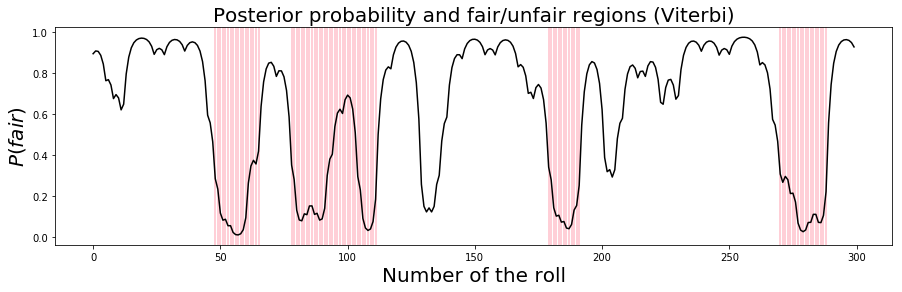

In [32]:
plt.figure(figsize=(15, 4))
plt.xlabel('Number of the roll', fontsize = 20)
plt.ylabel('$P(fair)$', fontsize=20)
for i in range(L):
    if path[i] == 0:
        plt.axvline(x = i, color ='white')
    else:
        plt.axvline(x = i, color = 'pink')
plt.title('Posterior probability and fair/unfair regions (Viterbi)', fontsize = 20)
plt.plot(range(L), post_prob_tutorial[:, 0], color = 'black')

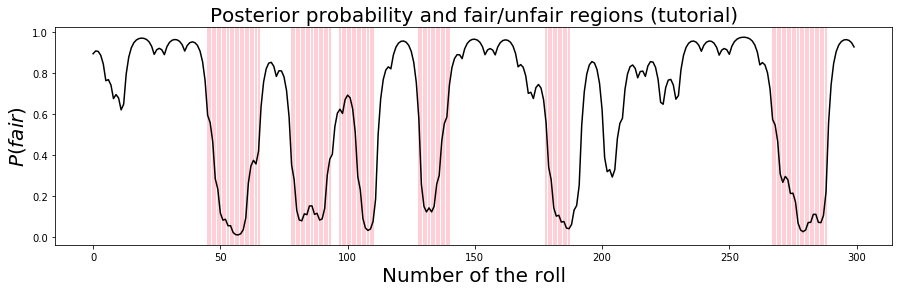

In [33]:
plt.figure(figsize=(15, 4))
plt.xlabel('Number of the roll', fontsize = 20)
plt.ylabel('$P(fair)$', fontsize = 20)
for i in range(L):
    if Die[i] == 0:
        plt.axvline(x = i, color ='white')
    else:
        plt.axvline(x = i, color = 'pink')
plt.title('Posterior probability and fair/unfair regions (tutorial)', fontsize = 20)
plt.plot(range(L), post_prob_tutorial[:, 0], color = 'black')

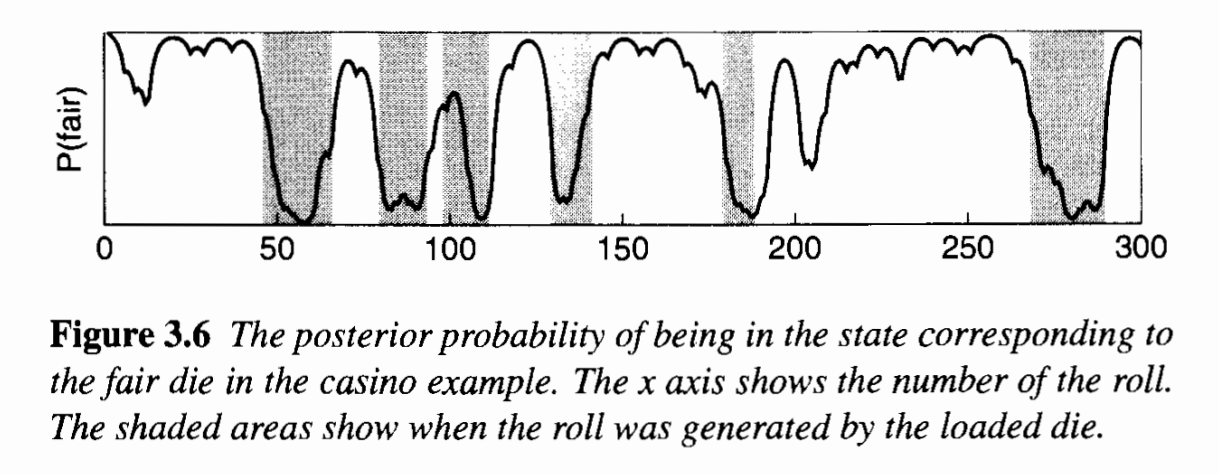